In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from scipy.stats import kstest, norm
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score



In [2]:

#1.  ___________________________CARICAMENDO DATASET_______________________
df = pd.read_csv('Student_Depression_Dataset.csv')
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [7]:
conteggi = df['Depression'].value_counts()

# Stampa i risultati
print(conteggi)

Depression
1    16336
0    11565
Name: count, dtype: int64


In [4]:

#2.  ___________________________PRE_PROCESSING_________________________________
#In questa fase andiamo a preparare i dati per le fasi successive


#EEsplorazione a livello generale dei miei del dataset
print(df.head())
print(df.describe())



# Controllo valori mancanti
print(df.isnull().sum())
#Solo "Financial Stress" risulta null in tre righe




#Non sapendo se le persone non hanno risposto alla domanda
#Perché hanno tanto o poco stress finanziario, utilizziamo la mediana (in questo caso 3)
median_value = df['Financial Stress'].median()  
df['Financial Stress'] = df['Financial Stress'].fillna(median_value)


#Esploro tutte le colonne che potrebbero non risultare rilevanti per lo studio per esempio 
#Esempio con id (ma ho esplorato anche Profession, city, Degree ecc...)
print(df['id'].value_counts())



#Elimino le colonne irrilevaniti per lo studio,
#id non contiene alcuna informazione utile ma serve soltanto come identificatore
#Profession non influisce molto sullo studio visto che su 27.901 persone 27.870 sono student
#Rimuoviamo "Work Pressure" perchè è correlato a profession
#Rimuoviamo  "Job Satisfaction" per la stessa ragione
df = df.drop(columns=['id']) 
df = df.drop(columns=['Profession'])
df = df.drop(columns=['Work Pressure'])
df = df.drop(columns=['Job Satisfaction'])

#Ricontrolliamo le colonne su cui verra condotto lo studio, dopo aver rimosso
#quelle che si ritengono non rilevanti ai fini dello studio
print(df.info())




#Tutti i dati sono presenti sotto forma numerica
#Si conclude la prima fase.


   id  Gender   Age           City Profession  Academic Pressure  \
0   2    Male  33.0  Visakhapatnam    Student                5.0   
1   8  Female  24.0      Bangalore    Student                2.0   
2  26    Male  31.0       Srinagar    Student                3.0   
3  30  Female  28.0       Varanasi    Student                3.0   
4  32  Female  25.0         Jaipur    Student                4.0   

   Work Pressure  CGPA  Study Satisfaction  Job Satisfaction  \
0            0.0  8.97                 2.0               0.0   
1            0.0  5.90                 5.0               0.0   
2            0.0  7.03                 5.0               0.0   
3            0.0  5.59                 2.0               0.0   
4            0.0  8.13                 3.0               0.0   

      Sleep Duration Dietary Habits   Degree  \
0          5-6 hours        Healthy  B.Pharm   
1          5-6 hours       Moderate      BSc   
2  Less than 5 hours        Healthy       BA   
3          7-8

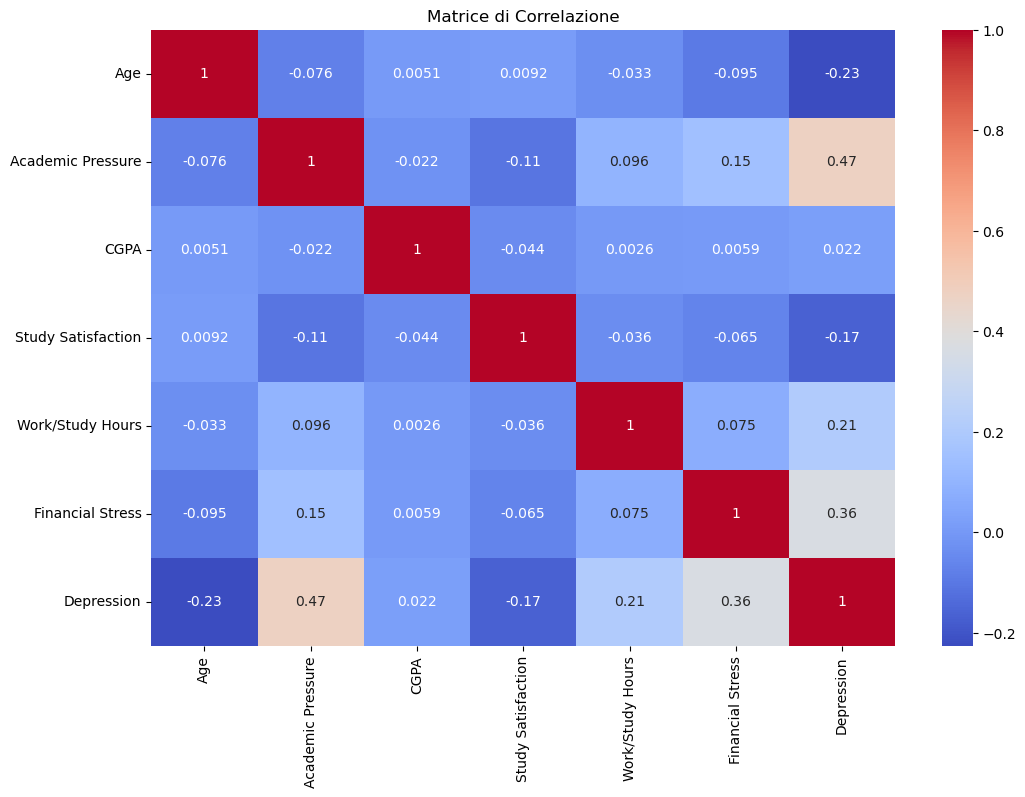

In [28]:

#3.  ___________________________EXPLORATORY DATA ANALYSIS (EDA)_________________________________

#Andremo a svolgere un indagine univariata, per capire come interagiscono 
#tra loro le singole varibili.

colonne_numeriche = df.select_dtypes(include='number')




# MATRICE DI CORRELAZIONE PER VARIABILI NUMERICHE
correlation_matrix = colonne_numeriche.corr()

# Visualizzazione della matrice

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice di Correlazione')
plt.show()






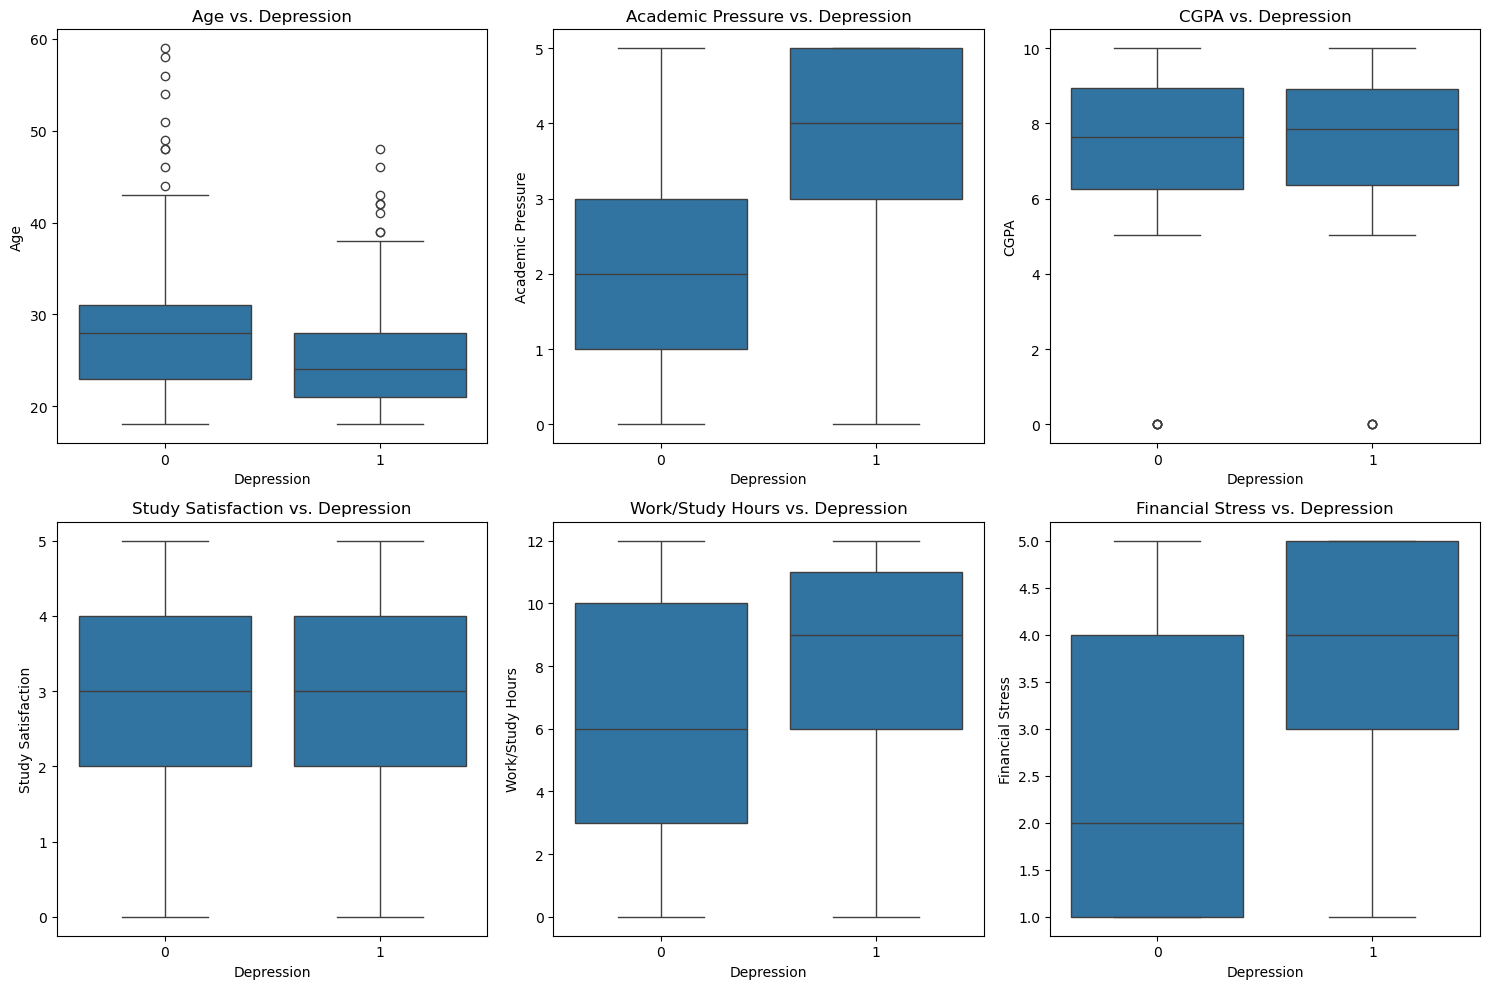

In [29]:

num_cols = [col for col in colonne_numeriche.columns if col != 'Depression']

# Determine the grid size for subplots
num_plots = len(num_cols)
rows = math.ceil(num_plots / 3)  # 3 plots per row (adjust as needed)
cols = min(num_plots, 3)

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust size
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot each boxplot
for i, col in enumerate(num_cols):
    sns.boxplot(x=df['Depression'], y=df[col], ax=axes[i])
    axes[i].set_title(f'{col} vs. Depression')
    axes[i].set_xlabel('Depression')
    axes[i].set_ylabel(col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


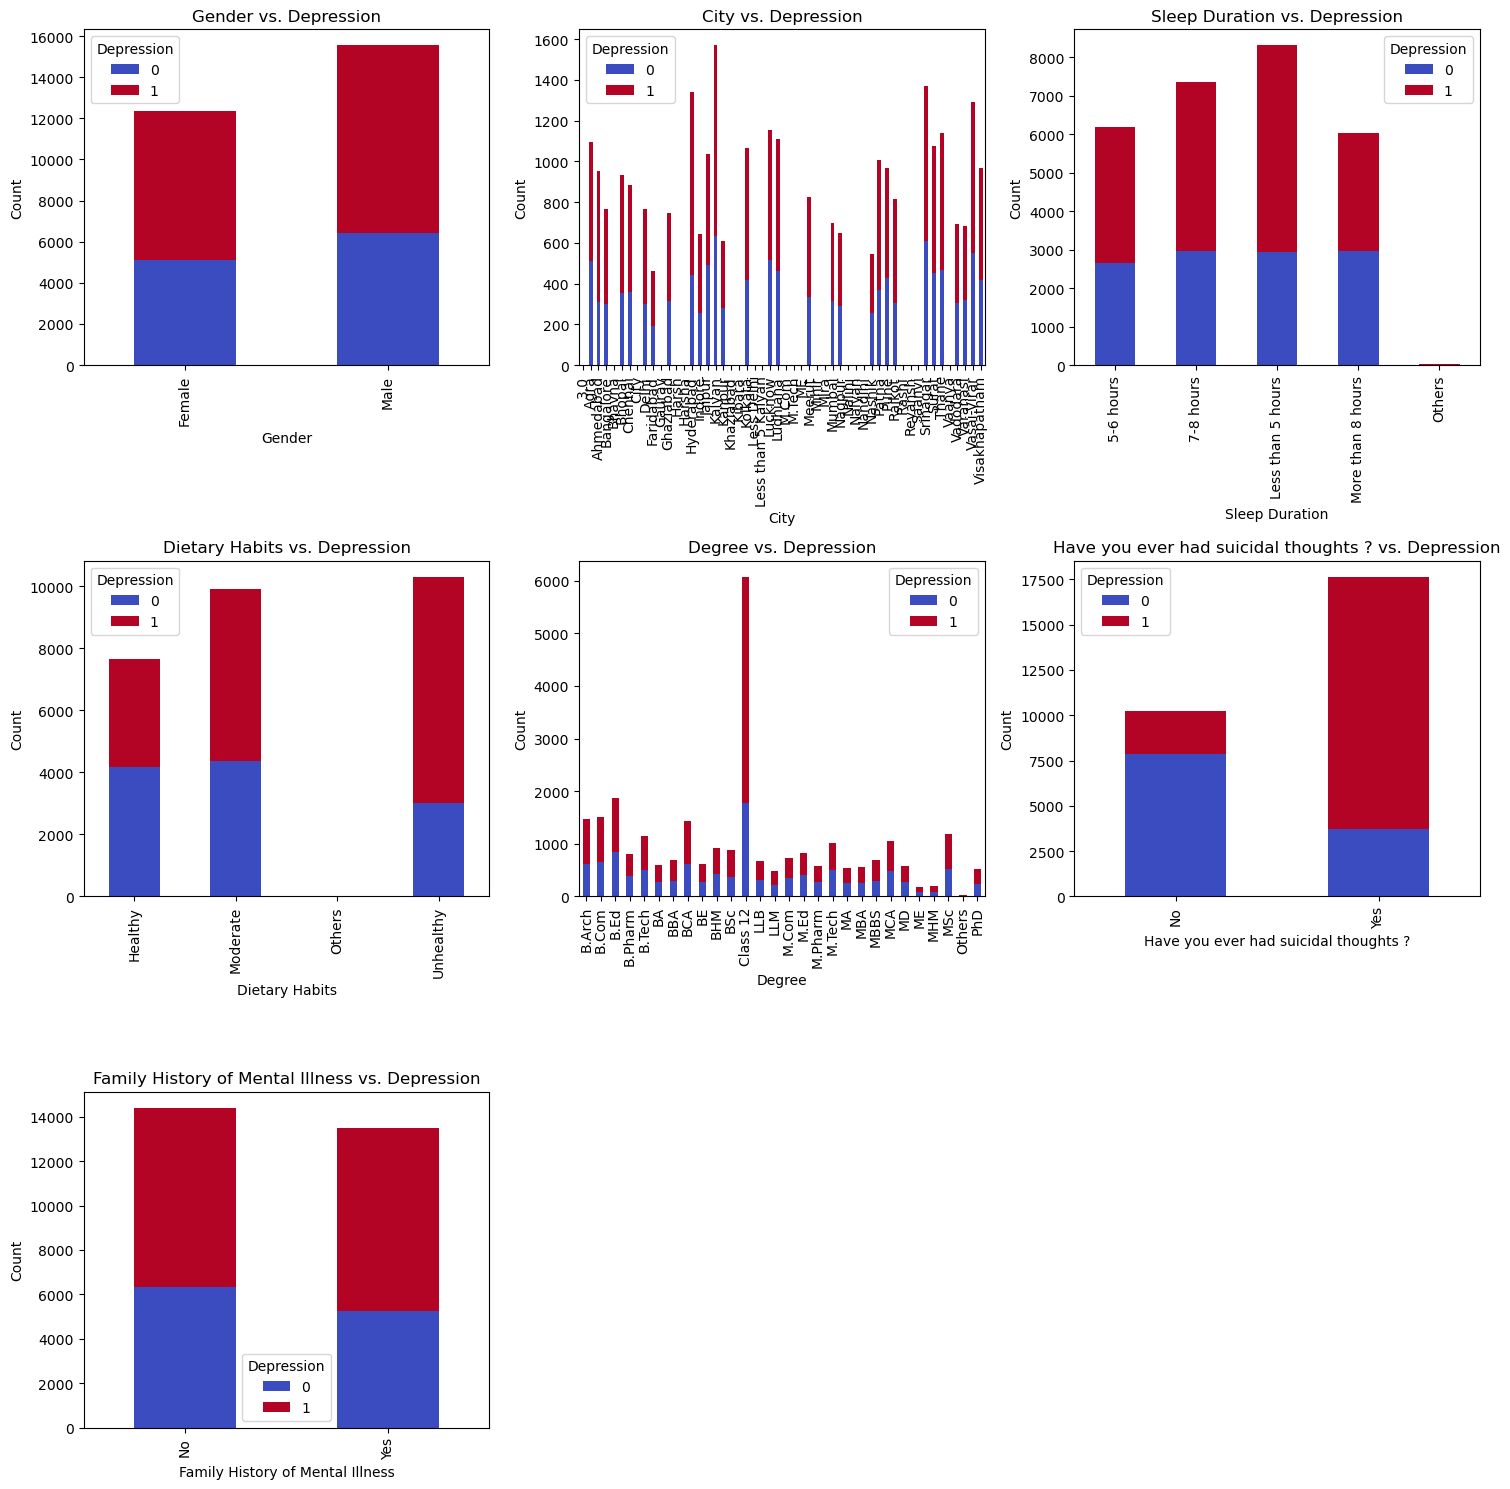

In [30]:




# Select categorical columns
cat_cols = [col for col in df.select_dtypes(include='object').columns]

# Determine the number of plots and grid size
num_plots = len(cat_cols)
rows = math.ceil(num_plots / 3)  # 3 plots per row
cols = min(num_plots, 3)

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easier iteration

# Plot each categorical variable against the target
for i, col in enumerate(cat_cols):
    # Create a grouped bar plot
    depression_counts = df.groupby([col, 'Depression']).size().unstack()
    depression_counts.plot(kind='bar', ax=axes[i], stacked=True, colormap='coolwarm')
    
    axes[i].set_title(f'{col} vs. Depression')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()



In [5]:

#4.  ___________________________SPLITTING_________________________________


#Divisione del dataset in training set e test set.
# Separiamo X (feature) e y (target)
X = df.drop(columns=['Depression'])  # Tutte le feature
y = df['Depression']  # Target

# Split iniziale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)




#Codifica delle dati Categorici in Numerici, modo che possano essere utilizzati dai Modelli 
#FACCIAMO LA CONVERSIONE DOPO AVER DIVISO IN TRAINING E TEST DATA PER EVITARE
#PERDITA DI DATI (IL MODELLO POTREBBE AVERE PIU INFORMAZIONI DI QUANTE DOVERBBE
#PERCHE ACQUISITE NELLA FASE DI ENCODING) 
#CI ASSICURIAMO CHE IL TEST SET RIMANGA NON VISTO(UNSEEN).

#                            -------------------CODIFICA TRAINING SET ----------------------
X_train = pd.get_dummies(X_train, columns=['Gender', 'City', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'], drop_first=True)

#print(X_TempEncode['Sleep Duration'].value_counts())

#Non possiamo utilizzare one-hot encoding per "Sleep Duration", perché non tiene conto dell'ordine
# Definire l'ordine


# converto "Sleep Duration" in una colonna categoriale con ordine specificato
X_train['Sleep Duration'] = pd.Categorical(
    X_train['Sleep Duration'],  
    categories=['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours', 'Others'],
    ordered=True
)

# Sostituisco i valori categorici con i valori interi(mantenendo l'ordine)
X_train['Sleep Duration'] = X_train['Sleep Duration'].cat.codes + 1  # Sommiamo 1 per partire da 1

#print(X_train.info())

# Salviamo tutte le colonne del training set
train_columns = X_train.columns





#DIVIDO TEST SET IN X_final_test e X_val 

X_val, X_final_test, y_val, y_final_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)




#                            -------------------CODIFICA TEST SET ----------------------
X_final_test = pd.get_dummies(X_final_test, columns=['Gender', 'City', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'], drop_first=True)

#print(X_TestEncode['Sleep Duration'].value_counts())

#Non possiamo utilizzare one-hot encoding per "Sleep Duration", perché non tiene conto dell'ordine
# Definire l'ordine


# converto "Sleep Duration" in una colonna categoriale con ordine specificato
X_final_test['Sleep Duration'] = pd.Categorical(
    X_final_test['Sleep Duration'],  
    categories=['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours', 'Others'],
    ordered=True
)

# Sostituisco i valori categorici con i valori interi(mantenendo l'ordine)
X_final_test['Sleep Duration'] = X_final_test['Sleep Duration'].cat.codes + 1  # Sommiamo 1 per partire da 1

#print(X_final_test.info())
# Allineo le colonne con il training set
X_final_test = X_final_test.reindex(columns=train_columns, fill_value=0)



#                            -------------------CODIFICA VALIDATION SET ----------------------
X_val = pd.get_dummies(X_val, columns=['Gender', 'City', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'], drop_first=True)

#print(X_TestEncode['Sleep Duration'].value_counts())

#Non possiamo utilizzare one-hot encoding per "Sleep Duration", perché non tiene conto dell'ordine
# Definire l'ordine


# converto "Sleep Duration" in una colonna categoriale con ordine specificato
X_val['Sleep Duration'] = pd.Categorical(
    X_val['Sleep Duration'],  
    categories=['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours', 'Others'],
    ordered=True
)

# Sostituisco i valori categorici con i valori interi(mantenendo l'ordine)
X_val['Sleep Duration'] = X_val['Sleep Duration'].cat.codes + 1  # Sommiamo 1 per partire da 1

#print(X_val.info())

# Allineo le colonne con il training set
X_val = X_val.reindex(columns=train_columns, fill_value=0)





# STAMPO A DISPLAY LE DIMENSIONI DI OGNI SUB-SET DI DATI
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_final_test.shape[0])





Training set size: 19530
Validation set size: 4185
Test set size: 4186


Intercetto: 2.64
Coefficiente: 0.16


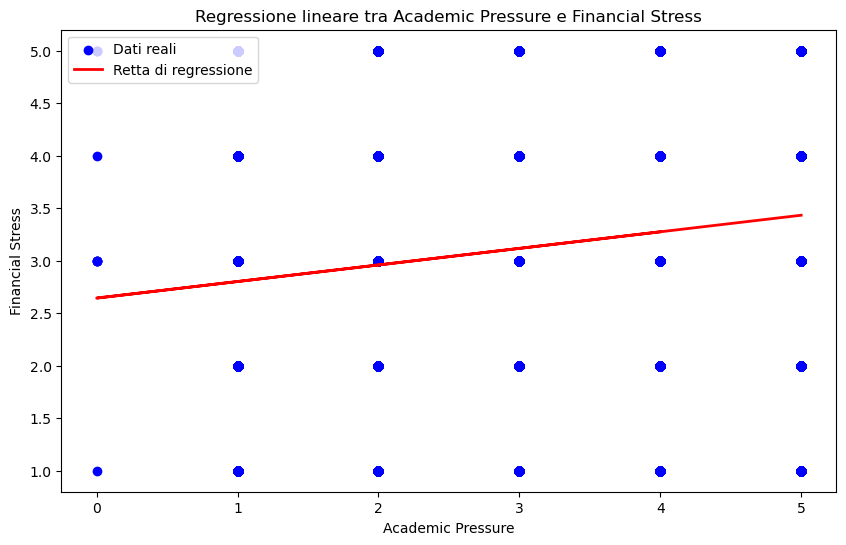

R^2: 0.02
MSE: 2.02
I residui non seguono una distribuzione normale (p-value: 0.00)


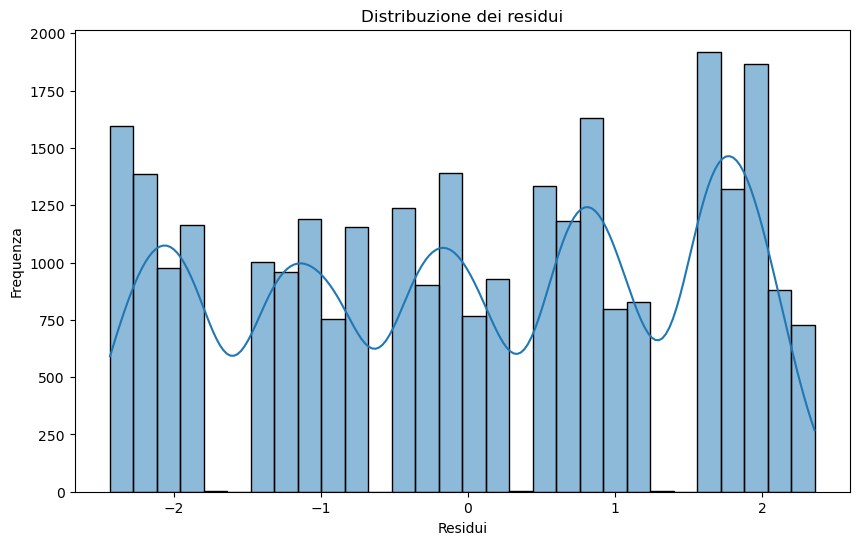

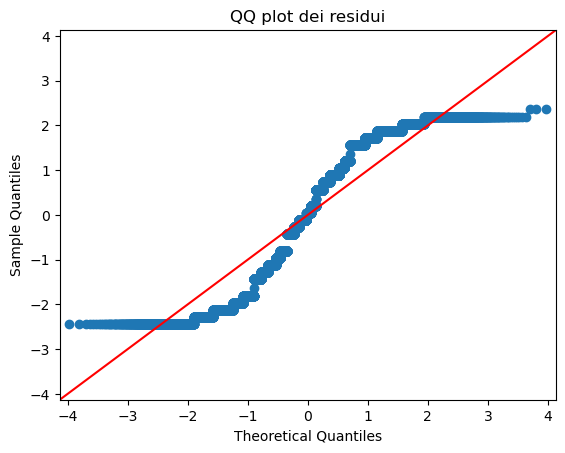

In [6]:

#5.  ___________________________REGERESSIONE_________________________________

#Osservando la matrice, si può notare che le variabili più fortemente correlate,
#sono "Academic Pressure" e "Depression", ma essendo la seconda, una variabile
#di tipo binario, la regressione lineare non è la soluzione ottimale (regressione logica lo sarebbe)

# Le colonne numeriche più fortemente correlate (positivamente) sono
#"Academic Pressure" e "Financial Stress", per questo vengono utilizzate
#per la regressione lineare
X = 'Academic Pressure' # Variabile indipendente
y = 'Financial Stress'  # Variabile dipendente

#preparazione delle variabili per la regressione 
X_reg = df[[X]].values
y_reg = df[y].values
#creazione e addestramento del modello di regressione lineare
reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)

#5.1: Stima Dei Coefficienti
intercept = reg_model.intercept_
coef = reg_model.coef_[0]
print(f'Intercetto: {intercept:.2f}')
print(f'Coefficiente: {coef:.2f}')
#predizione dei valori di y utilizzando il modello addestrato
y_pred_reg = reg_model.predict(X_reg)

#5.2: Grafico dei punti di maggior correlazione e della retta di regressione
plt.figure(figsize=(10, 6))
plt.scatter(X_reg, y_reg, color='blue', label='Dati reali')
plt.plot(X_reg, y_pred_reg, color='red', linewidth=2, label='Retta di regressione')
plt.xlabel(X)
plt.ylabel(y)
plt.title("Regressione lineare tra " + str(X) + " e " + str(y))
plt.legend()
plt.show()

#5.3: Calcolo del Coefficiente r^2
r2 = r2_score(y_reg, y_pred_reg)
print(f'R^2: {r2:.2f}')

#5.4: Calcolo del Valore di MSE
mse = mean_squared_error(y_reg, y_pred_reg)
print(f'MSE: {mse:.2f}')


# 5.5: Analisi di Normalità dei Residui con Kolmogorov-Smirnov Test
# Calcolo i residui facendo la differenza tra valori reali e valori predetti
residui = y_reg - y_pred_reg

# Parametri della distribuzione normale basati sui residui
mean_resid = residui.mean()
std_resid = residui.std()



# Test K-S per verificare la normalità
ks_stat, p_value_ks = kstest(residui, 'norm', args=(mean_resid, std_resid))
if p_value_ks > 0.05:
    print(f"I residui seguono una distribuzione normale (p-value: {p_value_ks:.2f})")
else:
    print(f"I residui non seguono una distribuzione normale (p-value: {p_value_ks:.2f})")


#creazione di un istogramma con sovrapposta la curva di densità dei residui
plt.figure(figsize=(10, 6))
sns.histplot(residui, kde=True)
plt.title("Distribuzione dei residui")
plt.xlabel("Residui")
plt.ylabel("Frequenza")
plt.show()   
#creazione del qqplot per la verifica di normalità dei residui
sm.qqplot(residui, line ='45')
plt.title('QQ plot dei residui')
plt.show()



In [7]:


#6.  ___________________________ADDESTRAMENTO MODELLO_________________________________


logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_val)
#valutazione delle prestazioni del modello di regressione logistica
acc_logistic = accuracy_score(y_val, y_pred_logistic)
print("Acc regressione logistica: {:.3f}".format(acc_logistic))

#SVM con kernel lineare
svm_linear_model = SVC(kernel='linear', C=1)
svm_linear_model.fit(X_train, y_train)
y_pred_svm_linear = svm_linear_model.predict(X_val)
#valutazione delle prestazioni del modello SVC lineare
acc_SVM_linear = accuracy_score(y_val, y_pred_svm_linear)
print("Acc SVM lineare: {:.3f}".format(acc_SVM_linear))

#SVM con kernel polinomiale
svm_poly_model = SVC(kernel='poly', degree=3, C=1)
svm_poly_model.fit(X_train, y_train)
y_pred_svm_poly = svm_poly_model.predict(X_val)
#valutazione delle prestazioni del modello SVC polinomiale
acc_SVM_poly = accuracy_score(y_val, y_pred_svm_poly)
print("Acc SVM polinomiale: {:.3f}".format(acc_SVM_poly))

#SVM con kernel RBF
svm_rbf_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf_model.fit(X_train, y_train)
y_pred_svm_rbf = svm_rbf_model.predict(X_val)
#valutazione delle prestazioni del modello SVC RBF
acc_SVM_rbf = accuracy_score(y_val, y_pred_svm_rbf)
print("Acc SVM rbf: {:.3f}".format(acc_SVM_rbf))



Acc regressione logistica: 0.849
Acc SVM lineare: 0.852
Acc SVM polinomiale: 0.853
Acc SVM rbf: 0.853


In [8]:


#7.  ___________________________HYPERPARAMETER TUNING_________________________________

#addestramento del modello SVM con kernel lineare
param_grid_linear = {
    'C': [0.1,1.0, 10.0]
}
grid_search_linear = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid_linear, cv=5, n_jobs=-1)
grid_search_linear.fit(X_train, y_train)
best_model_linear = grid_search_linear.best_estimator_
accuracy_linear = best_model_linear.score(X_val, y_val)
print("Acc SVM lineare ottimizzato: {:.3f}".format(accuracy_linear))

#addestramento del modello SVM con kernel polinomiale
param_grid_poly = {
    'C': [0.1,1.0,10.0],
    'gamma': ['scale'],
    'degree': [2,3,4]  
}
grid_search_poly = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=param_grid_poly, cv=5, n_jobs=-1)
grid_search_poly.fit(X_train, y_train)
best_model_poly = grid_search_poly.best_estimator_
accuracy_poly = best_model_poly.score(X_val, y_val)
print("Acc SVM polinomiale ottimizzato: {:.3f}".format(accuracy_poly))

#addestramento del modello SVM con kernel rbf
param_grid_rbf = {
    'C': [0.1,1.0,10.0],
    'gamma': ['scale']
}
grid_search_rbf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid_rbf, cv=5)
grid_search_rbf.fit(X_train, y_train)
best_model_rbf = grid_search_rbf.best_estimator_
accuracy_rbf = best_model_rbf.score(X_val, y_val)
print("Acc SVM rbf ottimizzato: {:.3f}".format(accuracy_rbf))




"""
"L'ottimizzazione degli iperparametri è stata condotta con un set limitato di valori per 
bilanciare l'accuratezza del modello e i tempi di elaborazione. Un'esplorazione più ampia
 avrebbe richiesto risorse computazionali non giustificabili dai miglioramenti marginali 
 in termini di accuratezza.
"""



Acc SVM lineare ottimizzato: 0.852


Il miglior modello è SVM rbf con un'accuratezza di 0.852


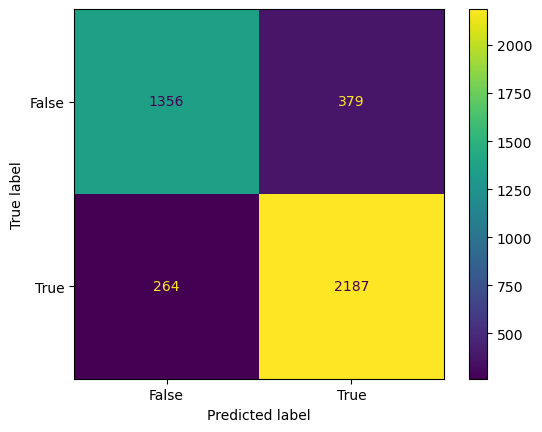

In [27]:
#8_______________________________________VALUTAZIONE DELLE PERFORMANCE__________________________________
#determino il miglior modello
acc = {
    "regressione logistica": acc_logistic,
    "SVM lineare": accuracy_linear,
    "SVM polinomiale": accuracy_poly,
    "SVM rbf": accuracy_rbf
}
#il nome del miglior modello e di conseguenza la sua accuratezza
best_model_name = max(acc, key=acc.get)
best_model_acc = acc[best_model_name]
print("Il miglior modello è " + best_model_name + " con un'accuratezza di {:.3f}".format(best_model_acc))
#valutazione delle performance con il miglior modello
if best_model_name == "regressione logistica":
    best_model = logistic_model
elif best_model_name == "SVM lineare":
    best_model = grid_search_linear
elif best_model_name == "SVM polinomiale":
    best_model = grid_search_poly
elif best_model_name == "SVM rbf":
    best_model = grid_search_rbf 
y_test_pred = best_model.predict(X_final_test)

#creo la matrice di confusione
#conf_matrix = metrics(y_final_test, y_test_pred)


confusion_matrix = metrics.confusion_matrix(y_final_test, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

# Plot and display the confusion matrix
cm_display.plot()
plt.show() 


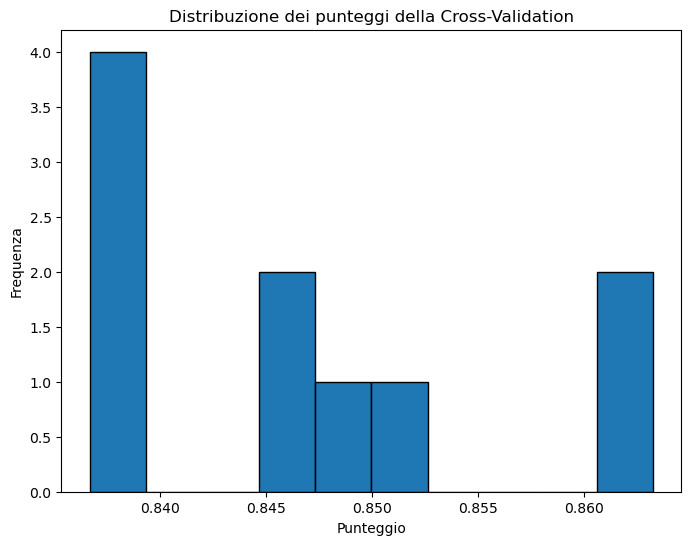

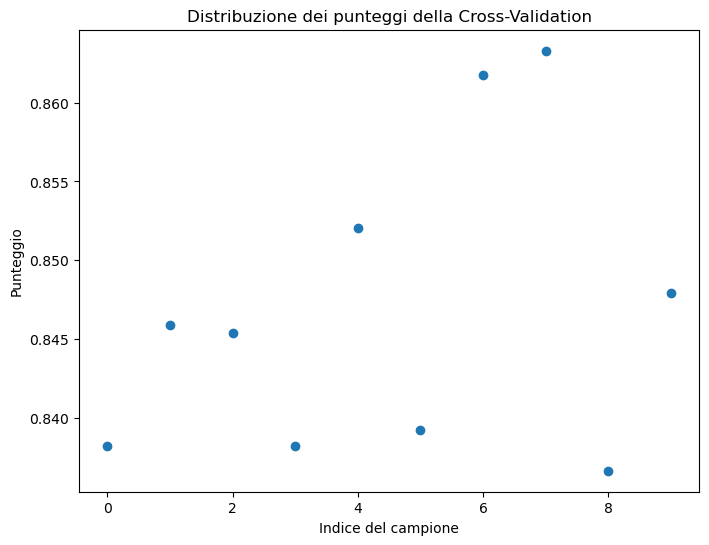

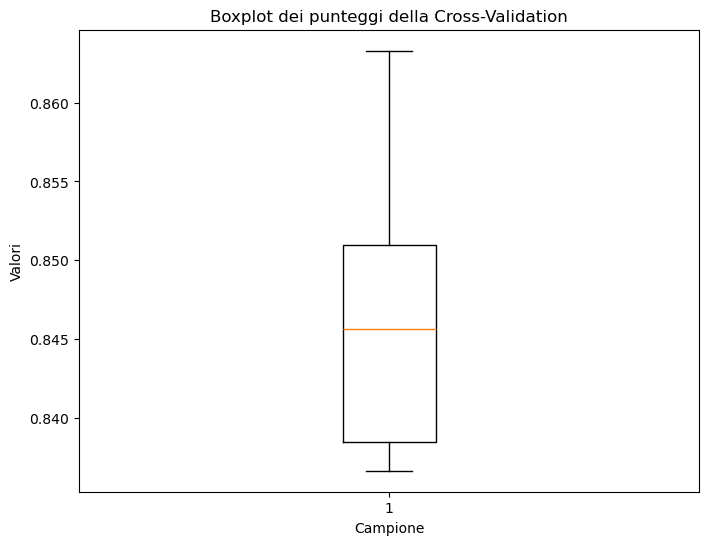

Media: 0.847
Deviazione standard: 0.009
Mediana: 0.846
Minimo: 0.837
Massimo: 0.863
Intervallo: 0.027
Intervallo di confidenza al 95%: [0.840, 0.853]


In [19]:
#9: Studio Statistico dei Risultati della Valutazione
#esecuzione della cross-validation con k ripetizioni (k >= 10)
k = 10
scores = cross_val_score(best_model_linear, X_train, y_train, cv=k, scoring='accuracy')

#calcolo delle metriche statistiche
mean_score = np.mean(scores)
std_score = np.std(scores)
median_score = np.median(scores)
min_score = np.min(scores)
max_score = np.max(scores)
range_score = max_score - min_score

#calcolo dell'intervallo di confidenza al 95%
alpha = 0.05
n = len(scores)
mean_std = std_score / np.sqrt(n)
#valore critico per k=10, alpha=0.05
t_value = 2.262  
lower_bound = mean_score - t_value * mean_std
upper_bound = mean_score + t_value * mean_std

#creazione del grafico istogramma
plt.figure(figsize=(8, 6))
plt.hist(scores, bins=10, edgecolor='black')
plt.xlabel("Punteggio")
plt.ylabel("Frequenza")
plt.title("Distribuzione dei punteggi della Cross-Validation")
plt.show()

#creazione del grafico scatter
plt.figure(figsize=(8, 6))
plt.scatter(range(len(scores)), scores)
plt.xlabel("Indice del campione")
plt.ylabel("Punteggio")
plt.title("Distribuzione dei punteggi della Cross-Validation")
plt.show()

#creazione del boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(scores)
plt.xlabel("Campione")
plt.ylabel("Valori")
plt.title("Boxplot dei punteggi della Cross-Validation")
plt.show()

#stampa dei risultati statistici
print(f"Media: {mean_score:.3f}")
print(f"Deviazione standard: {std_score:.3f}")
print(f"Mediana: {median_score:.3f}")
print(f"Minimo: {min_score:.3f}")
print(f"Massimo: {max_score:.3f}")
print(f"Intervallo: {range_score:.3f}")
print(f"Intervallo di confidenza al 95%: [{lower_bound:.3f}, {upper_bound:.3f}]")